# Testing Tenor Log Mel Spectrogram with Convolutional Neural Network

Here we test a convolutional neural network on log Mel spectrogram data extracted from our WAV samles. Each log Mel spectrogram has 96 x 431 = 41,376 features, where 96 is the number of frequency bands, and 431 is the number of time slices (collections of 512 raw samples). So this is a lot of data.

Upstream from this notebook we extracted these features and saved them as pickles, then we read all the pickles and aggregated them into a Pandas DataFrame, again saved as a pickle. Finally, with the imported `_tenor_lms` (below) we read from this pickle, filter and reshape the data as needed, and then we scale data using `sklearn.preprocessing.StandardScaler`. At this point, data are ready to read into our notebook.

In this notebook we define, train, and test a CNN with these log Mel spectrogram data as input.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_lms import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_lms.py`.

In [3]:
# Just take a quick look at the data
lmss.head()

,lms_0_0,lms_0_1,lms_0_2,lms_0_3,lms_0_4,lms_0_5,lms_0_6,lms_0_7,lms_0_8,lms_0_9,...,lms_95_421,lms_95_422,lms_95_423,lms_95_424,lms_95_425,lms_95_426,lms_95_427,lms_95_428,lms_95_429,lms_95_430
0,-10.317123,-9.347862,-4.298318,-5.357454,-6.131017,-10.290504,-11.726788,-12.304592,-7.372962,-5.804662,...,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237,-53.895237
3,23.457136,19.467508,16.852650,18.549463,19.527157,17.356018,18.098804,19.481676,18.789204,19.858055,...,-49.076561,-49.076561,-49.076561,-49.076561,-49.076561,-49.076561,-47.107056,-48.521732,-49.076561,-49.076561
4,-3.468037,-2.749898,-1.760237,-0.949083,-3.888841,0.506936,-2.559750,-7.962342,-2.952751,-2.990458,...,-44.389835,-47.545021,-54.222561,-54.222561,-54.222561,-54.222561,-54.222561,-54.222561,-54.222561,-54.222561
5,1.037112,0.922007,0.948512,1.771491,3.059099,3.167582,3.294528,1.661538,-0.046466,-1.928239,...,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407,-58.301407
7,6.403664,2.453652,0.177524,-4.925104,-5.808710,-4.428904,-6.851029,-11.506468,-7.577614,-4.405732,...,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801,-50.167801


In [4]:
print(data.shape)  # We should have 41376 = 431 x 96 columns
print(target.shape)

(5662, 41376)
(5662,)


In [5]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [6]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

# Plot example training instance

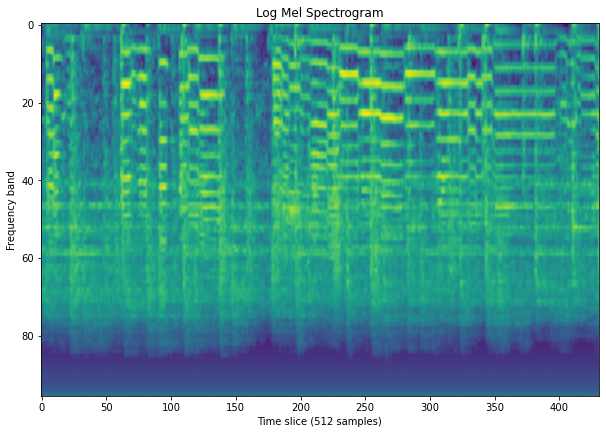

In [8]:
# Just take a little peek at our data
plt.figure(figsize=(10, 10))
plt.xlabel("Time slice (512 samples)")
plt.ylabel("Frequency band")
plt.title("Log Mel Spectrogram")
# plt.colorbar()
plt.imshow(x_train[13, :, :, 0], aspect=3.0)  
# First number in the list ^ is the nth training sample
pass

# Train the CNN
This may take between 45 and 70 minutes per epoch

In [8]:
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# https://www.tensorflow.org/tutorials/images/cnn
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
# https://keras.io/api/layers/reshaping_layers/flatten/
# https://keras.io/api/layers/core_layers/dense/
# Architecture based in part on 
#   https://www.kaggle.com/ashirahama/simple-keras-cnn-with-mfcc
model = Sequential()
# Conv2D (from the docs)
# 2D convolution layer (e.g. spatial convolution over images).
# This layer creates a convolution kernel that is convolved with 
# the layer input to produce a tensor of outputs. 
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
# MaxPooling2D (from the docs)
# "Downsamples the input representation by taking the maximum value over the 
# window defined by pool_size for each dimension along the features axis. 
# The window is shifted by strides in each dimension. The resulting output 
# when using "valid" padding option has a shape (number of rows or columns) 
# of: output_shape = (input_shape - pool_size + 1) / strides)""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)
loss, recall = model.evaluate(x_test, y_test)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3623 samples, validate on 906 samples
Epoch 1/3
3623/3623 [==============================] - 1348s 372ms/step - loss: 1.1143 - recall: 0.7608 - val_loss: 0.3751 - val_recall: 0.7754
Epoch 2/3
3623/3623 [==============================] - 1309s 361ms/step - loss: 0.3156 - recall: 0.8611 - val_loss: 0.2898 - val_recall: 0.8559
Epoch 3/3
1133/1133 [==============================] - 53s 47ms/step


In [9]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

1133/1133 [==============================] - 48s 42ms/step
Recall: 94.02


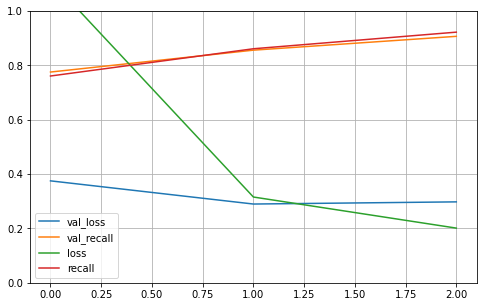

In [10]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
